In [82]:
from __future__ import division, print_function, absolute_import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

import pickle
import random
import re

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate, GroupKFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import hmean
import xgboost as xgb
from sklearn.dummy import DummyRegressor

In [2]:
# Load Data Sets from CSV files
# df20 are patter based features (i.e signatures based on presence or absence of a AA)
# dfvz is the experimental data combined with features i.e zhse v-scale factors etc. 

dfvz = pd.read_csv('../DataFiles/experimental_data_set.csv', engine='c', index_col=0)
df20 = pd.read_csv('../DataFiles/df20.csv', engine='c', index_col=0)

# Indices of both DFs are matched during pre-processing so keep that in check!

In [3]:
def filter_data(dfvz=dfvz):
    # Filter Includes All Samples Containing Cysteine
    filter_cys = dfvz['seq'].str.contains('C')

    # Filter Includes All Samples Containing Proline in First Position but not in Second Position
    # I.e PCEQ is included but not PPEQ
    filter_proline = dfvz['seq'].str.contains('(^P[^P])')

    # Combined Filter to select any samples that satisfy either condition!
    filter_proline_cysteine = dfvz['seq'].str.contains('(^P[^P])|([C])')

    # Create index so it can be used for both DF20 and DFVZ (inverted to remove filtered rows)
    idx_filter_inverted = dfvz[~filter_proline_cysteine].index.to_list()

    print(f'Original Data Set Samples: {len(dfvz)}\
        \nSamples Containing Cystiene Residues: {len(dfvz[filter_cys])}\
        \nSamples Containing Proline (But Not Proline-Proline) {len(dfvz[filter_proline])}\
        \nTotal Samples that satisfy either condition (Some Overlap) {len(dfvz[filter_proline_cysteine])}\
        \nFinal Samples Used: {len(idx_filter_inverted)}\
        \nPercentage Removed: {len(idx_filter_inverted)/len(dfvz):.2%}')
    
    return idx_filter_inverted

filtered_indices = filter_data()

# Removes all Samples Containing C and PXXX where X != P
dfvz = dfvz.loc[filtered_indices]
df20 = df20.loc[filtered_indices]

Original Data Set Samples: 67278        
Samples Containing Cystiene Residues: 2740        
Samples Containing Proline (But Not Proline-Proline) 4328        
Total Samples that satisfy either condition (Some Overlap) 6846        
Final Samples Used: 60432        
Percentage Removed: 89.82%


### Use Standard Scaler on Features

$$ z = \frac{x-\mu}{\sigma}$$
Essentially, centers and scales the features. This is done column wise / feature wise. 

In [29]:
# This distribution of features allows us to experiment with each group individual as needed. 
# For now, we just need Xpvz_s and Xpvz_names. 
# Functionalized to reduce use of memory for variables
def scale_data(dfvz=dfvz, df20=df20):
    standard_scaler = preprocessing.StandardScaler()

    Xp = df20.loc[:,'..AA':'V...'].values #sequence pattern descriptors #(67278, 2396)
    Xp_names = df20.loc[:,'..AA':'V...'].columns
    standard_scaler.fit(Xp)
    Xp_s= standard_scaler.transform(Xp)

    Xz=dfvz.loc[:,'z1.1':'z4.3'].values #zscale descriptors #(67278, 12)
    Xz_names = dfvz.loc[:,'z1.1':'z4.3'].columns
    standard_scaler.fit(Xz)
    Xz_s= standard_scaler.transform(Xz)

    Xv=dfvz.loc[:,'vhse1.1':'vhse4.8'].values #vhse descriptors #(67278, 32)
    Xv_names = dfvz.loc[:,'vhse1.1':'vhse4.8'].columns
    standard_scaler.fit(Xv)
    Xv_s= standard_scaler.transform(Xv)

    Xvz_names = list(Xz_names)+list(Xv_names) #zscale and vhse combined #(67278, 44)
    Xvz=dfvz.loc[:,Xvz_names].values
    standard_scaler.fit(Xvz)
    Xvz_s= standard_scaler.transform(Xvz)

    Xpvz_names = list(Xvz_names)+list(Xp_names)#pattern and zscale, vhse combined #(67278, 2440)
    Xpvz=pd.concat([dfvz.loc[:,Xvz_names],df20.loc[:,list(Xp_names)]],axis=1).values
    standard_scaler.fit(Xpvz)
    Xpvz_s= standard_scaler.transform(Xpvz)

    y = dfvz['log.label'].values.reshape(-1,1)

    # The following dictionary makes it much easier to main and access data. 

    keys = ['Xp', 'Xp_s', 'Xz', 'Xz_s', 'Xv', 'Xv_s', 'Xvz', 'Xvz_s', 'Xpvz', 'Xpvz_s']
    vals = [Xp, Xp_s, Xz, Xz_s, Xv,Xv_s, Xvz, Xvz_s, Xpvz, Xpvz_s]
    name_vals = [Xp_names, Xp_names, Xz_names, Xz_names, Xv_names, Xv_names, Xvz_names, Xvz_names, Xpvz_names, Xpvz_names]

    X_dict = dict(zip(keys, vals))
    Xname_dict = dict(zip(keys, name_vals))

    # Y - Values, subdivided according to this: 
    # Real: Real Values used for regressor
    # 3class: 0, 1, 2 - Bottom 5%, Middle 90%, Top 5%
    threashold = 0.05
    y_three_class = pd.qcut(dfvz['log.label'], q = [0, threashold, 1-threashold, 1], labels=False).values
    y_low = np.array([True if x == 0 else False for x in y_three_class])
    y_high = np.array([True if x == 2 else False for x in y_three_class])
    ykey = ['real', '3class', 'low', 'high']
    yval = [y, y_three_class, y_low, y_high]
    y_dict = dict(zip(ykey, yval))

    return X_dict, Xname_dict, y_dict

X_dict, Xname_dict, y_dict = scale_data()

In [30]:
# Assign X & y values to be used for training/testing etc. 
X = X_dict['Xpvz_s']
y = y_dict['real']

# Details about the current data and its range:
print(f'Y - Value: LogDC \
    \nMax Y Value: {np.max(y)} \nMin Y Value: {np.min(y)} \
    \nAverage Y Value: {np.average(y)} \
    \nLength of Y: {len(y)} \
    \nShape of X: {X.shape}')

Y - Value: LogDC     
Max Y Value: -1.826188 
Min Y Value: -4.439897     
Average Y Value: -2.7528466023779985     
Length of Y: 60432     
Shape of X: (60432, 2440)


## Test Performance of Regressor in a Cross-Validation Setting

The final model will be trained on all of the data. 

In [37]:
scoring = {'mse':'neg_mean_squared_error', 'r2':'r2', 'mae':'neg_mean_absolute_error'}

def test_model(estimator, X, y, scoring=scoring, cv=5):
    scores = cross_validate(estimator, X, y, scoring=scoring, cv=cv, return_train_score=True, n_jobs=5)
    df = pd.DataFrame(scores)
    return df

In [38]:
# Parameters based on optimization done previously. 
params = {'n_estimators': 500,
          'learning_rate': 0.01,
          'objective':'reg:squarederror',                                   
          'n_jobs':-1,
          'verbosity':1,
          'tree_method':'gpu_hist'
          }

In [47]:
regression_model = xgb.XGBRegressor(**params)
dummy_model = DummyRegressor(strategy='mean')
score_df_xgb = test_model(regression_model, X, y, cv=5)
score_df_dummy = test_model(dummy_model, X, y, cv=5)

In [48]:
score_combined = pd.concat([score_df_xgb, score_df_dummy], keys=['xgb', 'dummy'])
aggregated_scores = score_combined.groupby(level=0).agg({'test_mse':['mean','std'],\
    'test_r2':['mean', 'std'],
    'test_mae':['mean', 'std']})

aggregated_scores.to_csv('summary_scores_regressor.csv')

## Train Regressor on Entire Data Set & Compute Statistics

In [71]:
X_train, X_validate, y_train, y_validate = train_test_split(
    X, y, test_size=0.1, stratify=y_dict['3class'], shuffle=True, random_state=42
)

regression_model_final = xgb.XGBRegressor(**params)
regression_model_final.fit(
    X_train, y_train,
    eval_set=[(X_validate, y_validate)],
    early_stopping_rounds=3,
    eval_metric=['mae', 'rmse']
)


alidation_0-mae:0.72172	validation_0-rmse:0.77512
[150]	validation_0-mae:0.71452	validation_0-rmse:0.76839
[151]	validation_0-mae:0.70739	validation_0-rmse:0.76174
[152]	validation_0-mae:0.70033	validation_0-rmse:0.75516
[153]	validation_0-mae:0.69335	validation_0-rmse:0.74867
[154]	validation_0-mae:0.68644	validation_0-rmse:0.74224
[155]	validation_0-mae:0.67959	validation_0-rmse:0.73589
[156]	validation_0-mae:0.67281	validation_0-rmse:0.72960
[157]	validation_0-mae:0.66611	validation_0-rmse:0.72339
[158]	validation_0-mae:0.65947	validation_0-rmse:0.71725
[159]	validation_0-mae:0.65290	validation_0-rmse:0.71119
[160]	validation_0-mae:0.64641	validation_0-rmse:0.70519
[161]	validation_0-mae:0.63999	validation_0-rmse:0.69926
[162]	validation_0-mae:0.63363	validation_0-rmse:0.69341
[163]	validation_0-mae:0.62733	validation_0-rmse:0.68762
[164]	validation_0-mae:0.62109	validation_0-rmse:0.68189
[165]	validation_0-mae:0.61493	validation_0-rmse:0.67624
[166]	validation_0-mae:0.60882	validat

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan,
             monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
             n_estimators=500, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=1)

In [158]:
# Assign weight 3 to top and bottom 5 to optimize for them! 
weights = [2 if (x == 1) or (x == 2) else 1 for x in y_dict['3class']]
X_train, X_validate, y_train, y_validate, weights_train, weights_test = train_test_split(
    X, y, weights, test_size=0.1, stratify=y_dict['3class'], shuffle=True, random_state=42
)

regression_model_weighted = xgb.XGBRegressor(**params)
regression_model_weighted.fit(
    X_train, y_train,
    eval_set=[(X_validate, y_validate)],
    early_stopping_rounds=3,
    eval_metric=['mae', 'rmse'],
    sample_weight=weights_train
)

alidation_0-mae:0.73791	validation_0-rmse:0.79065
[150]	validation_0-mae:0.73075	validation_0-rmse:0.78394
[151]	validation_0-mae:0.72366	validation_0-rmse:0.77732
[152]	validation_0-mae:0.71665	validation_0-rmse:0.77076
[153]	validation_0-mae:0.70970	validation_0-rmse:0.76428
[154]	validation_0-mae:0.70284	validation_0-rmse:0.75787
[155]	validation_0-mae:0.69603	validation_0-rmse:0.75154
[156]	validation_0-mae:0.68929	validation_0-rmse:0.74527
[157]	validation_0-mae:0.68263	validation_0-rmse:0.73908
[158]	validation_0-mae:0.67603	validation_0-rmse:0.73296
[159]	validation_0-mae:0.66950	validation_0-rmse:0.72691
[160]	validation_0-mae:0.66303	validation_0-rmse:0.72092
[161]	validation_0-mae:0.65664	validation_0-rmse:0.71501
[162]	validation_0-mae:0.65030	validation_0-rmse:0.70917
[163]	validation_0-mae:0.64403	validation_0-rmse:0.70339
[164]	validation_0-mae:0.63784	validation_0-rmse:0.69767
[165]	validation_0-mae:0.63170	validation_0-rmse:0.69203
[166]	validation_0-mae:0.62562	validat

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan,
             monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
             n_estimators=500, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=1)

In [204]:
def custom_scorer(y_true, y_predicted):
    r2 = r2_score(y_true, y_predicted)
    mae = mean_absolute_error(y_true, y_predicted)
    rmse = np.sqrt(mean_squared_error(y_true, y_predicted))
    return {'r2':r2, 'mae':mae, 'rmse':rmse}



def test_weighted(trained_models_with_names, X, y):
    X_top, y_top = X[y_dict['high']], y[y_dict['high']]
    X_bottom, y_bottom = X[y_dict['low']], y[y_dict['low']]

    f, axes = plt.subplots(3,2, figsize=(15,10))

    scores_dict_top = {}
    scores_dict_bottom = {}
    for i, (name, model) in enumerate(trained_models_with_names.items()):
        print(f'Testing Model {name}')
        
        predictions_top = model.predict(X_top)
        predictions_bottom = model.predict(X_bottom)

        sns.distplot(predictions_top, color='red', ax=axes[i,0])
        sns.distplot(y_top, color='blue', ax=axes[i,0])
        axes[i,0].set(xlim=(-4.7,-1.8))

        sns.distplot(predictions_bottom, color='red', ax=axes[i,1])
        sns.distplot(y_bottom, color='blue', ax=axes[i,1])
        axes[i,1].set(xlim=(-4.7,-1.8))
        

        # print(f'Real Y-Top Values: \n{y_top[0:5]}\
        #     \nPredicted Top Values: \n{predictions_top[0:5].reshape(-1,1)}\
        #     \nReal Y-Bot Values: \n{y_bottom[0:5]}\
        #     \nPredicted Bot Values: \n{predictions_bottom[0:5].reshape(-1,1)}\n')
        scores_dict_top[name] = custom_scorer(y_top, predictions_top)
        scores_dict_bottom[name] = custom_scorer(y_bottom, predictions_bottom)

    predict_base = trained_models_with_names['base'].predict(X)
    predict_weighted = trained_models_with_names['weighted_model'].predict(X)
    

    sns.distplot(y, color='green', ax=axes[2,0])
    sns.distplot(predict_base, color='red', ax=axes[2,0])

    sns.distplot(y, color='green', ax=axes[2,1])
    sns.distplot(predict_weighted, color='red', ax=axes[2,1])
    axes[2,0].set(title='Full Data Distribution')

    axes[2,0].set(xlim=(-4.7,-1.8))
    axes[2,1].set(title='Full Data Distribution')
    axes[2,1].set(xlim=(-4.7,-1.8))
    return scores_dict_top, scores_dict_bottom



Testing Model base
Testing Model weighted_model


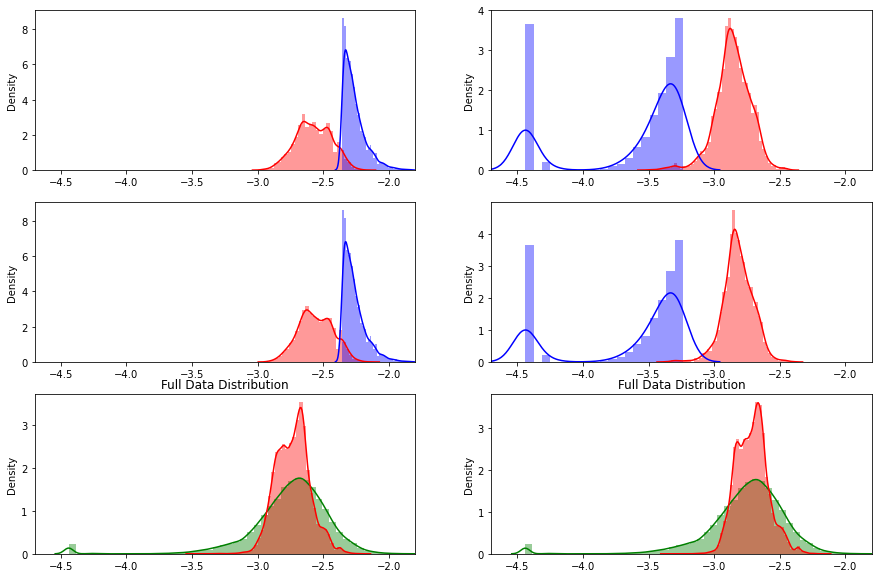

In [205]:
score_top, score_bottom = test_weighted({'base':regression_model_final, 'weighted_model':regression_model_weighted},\
    X, y)

In [187]:
pd.DataFrame(score_top).to_csv('top500_scores.csv')
pd.DataFrame(score_bottom).to_csv('bot500_scores.csv')

In [184]:
score_bottom

{'base': {'r2': -2.7558055844684457,
  'mae': 0.7792920232701437,
  'rmse': 0.9001540157580075},
 'weighted_model': {'r2': -3.0790493747670977,
  'mae': 0.8191222849796586,
  'rmse': 0.9380905320615294}}